# Evaluation

How often do regular differential expression analysis vs sophie prioritize the specific vs generic genes?

1. Simulate 1 template perturbation experiment using the technique above
2. Apply SOPHIE to get ranking of specific and generic genes based on their z-score.
3. Apply traditional DE analysis and get ranking of specific and generic genes based on their log fold change value
4. Compare the difference in ranking between specific and generic genes using SOPHIE vs traditional metrics.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
%matplotlib inline
import os
import glob
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from rpy2.robjects import pandas2ri
from ponyo import utils, train_vae_modules, simulate_expression_data
from generic_expression_patterns_modules import (
    process,
    new_experiment_process,
    stats,
    ranking,
)

np.random.seed(1)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = "config_sophie_vs_trad.tsv"

params = utils.read_config(config_filename)

In [3]:
# Load config params

# Local directory to store intermediate files
local_dir = params["local_dir"]

#
dataset_name = params["dataset_name"]

# File containing un-normalized template experiment
raw_template_filename = params["raw_template_filename"]

# Un-normalized compendium filename
raw_compendium_filename = params["raw_compendium_filename"]

# Normalized compendium filename
normalized_compendium_filename = params["normalized_compendium_filename"]

# ID for template experiment to be selected
project_id = params["project_id"]

# Number of simulated experiments to generate
num_runs = params["num_simulated"]

# Directory containing trained VAE model
vae_model_dir = params["vae_model_dir"]

# Size of the latent dimension
latent_dim = params["latent_dim"]

# Scaler transform used to scale compendium data into 0-1 range for training
scaler_filename = params["scaler_filename"]

# Which DE method to use
# We recommend that if data is RNA-seq then use DESeq2
# If data is microarray then use Limma
de_method = params["DE_method"]

# If using DE-seq, setting this parameter will
# remove genes below a certain threshold
count_threshold = params["count_threshold"]

# Metadata file that specifies which samples to keep for DE analysis (Optional)
template_process_samples_filename = params["template_process_samples_filename"]

# Metadata file that specifies sample grouping for DE analysis
template_DE_grouping_filename = params["template_DE_grouping_filename"]

# Statistic to use to rank genes or pathways by
col_to_rank_genes = params["rank_genes_by"]

# Pickle files saving specific and generic gene ids
template_specific_gene_ids_filename = params["template_specific_gene_ids_filename"]
generic_gene_ids_filename = "generic_gene_ids.pickle"

In [4]:
# Files generated by this notebook

# File storing template experiment with gene ids mapped to compendium gene ids
mapped_template_filename = params["mapped_template_filename"]

# File storing normalized template experiment
normalized_template_filename = params["normalized_template_filename"]

# File storing processed template experiment,
# after samples have been selected for comparison in DE analysis
processed_template_filename = params["processed_template_filename"]

# Output summary file
output_filename = params["output_filename"]

In [5]:
# Process template
new_experiment_process.process_template_experiment(
    raw_template_filename,
    raw_compendium_filename,
    scaler_filename,
    mapped_template_filename,
    normalized_template_filename,
)

(8, 1000)
(720, 1000)


## Quick check

In [6]:
# Check that normalized and applying scaler generate the same data

normalized_template_filename = params["normalized_template_filename"]

normalized_template = pd.read_csv(
    normalized_template_filename, sep="\t", index_col=0, header=0
)
normalized_template.head(10)

,G_0,G_1,G_2,G_3,G_4,G_5,G_6,G_7,G_8,G_9,...,G_990,G_991,G_992,G_993,G_994,G_995,G_996,G_997,G_998,G_999
0_control,0.114003,0.116113,0.001288,0.000340,0.000000,0.002734,0.058944,0.000000,0.658839,0.020941,...,0.000264,0.000665,0.031963,0.000000,0.002248,0.014075,0.101308,0.014467,0.001393,0.002393
1_control,0.073833,0.106016,0.001288,0.000340,0.001048,0.002133,0.087775,0.000126,0.617321,0.026740,...,0.000352,0.000416,0.014460,0.000000,0.000999,0.019571,0.125244,0.017722,0.001203,0.001197
2_control,0.072984,0.063105,0.001288,0.000681,0.001048,0.001531,0.060866,0.000126,0.567161,0.054124,...,0.000088,0.000665,0.012177,0.000000,0.001249,0.012735,0.079599,0.010850,0.001647,0.002074
3_control,0.072419,0.082036,0.001546,0.000340,0.001572,0.001641,0.075602,0.000000,0.719519,0.043814,...,0.000264,0.000665,0.016743,0.000286,0.002123,0.020509,0.111049,0.015913,0.000570,0.001276
4_perturb,0.038755,0.063946,0.002061,0.000000,0.000000,0.000766,0.070477,0.000126,0.512869,0.039304,...,0.000088,0.000832,0.011416,0.000572,0.001998,0.020241,0.093515,0.011935,0.002027,0.001835
5_perturb,0.053465,0.085822,0.001804,0.000000,0.000524,0.002078,0.083931,0.000000,0.515217,0.040915,...,0.000176,0.000665,0.024353,0.000000,0.002373,0.017828,0.086001,0.010488,0.000760,0.002074
6_perturb,0.073267,0.084560,0.001546,0.000000,0.000524,0.001586,0.062148,0.000126,0.397708,0.033505,...,0.000264,0.000582,0.012938,0.000000,0.002373,0.015818,0.097133,0.013743,0.001520,0.001755
7_perturb,0.082320,0.113168,0.000773,0.001021,0.000524,0.002023,0.089698,0.000126,0.539639,0.033183,...,0.000088,0.000832,0.019026,0.000000,0.001748,0.021984,0.139716,0.013020,0.001900,0.000718


In [7]:
# Load scaler file
scaler_transform = pickle.load(open(scaler_filename, "rb"))

template_experiment = pd.read_csv(
    raw_template_filename, sep="\t", index_col=0, header=0
)

template_experiment_scaled = scaler_transform.transform(template_experiment)

template_experiment_scaled_df = pd.DataFrame(
    template_experiment_scaled,
    columns=template_experiment.columns,
    index=template_experiment.index,
)
template_experiment_scaled_df.head(10)

,G_0,G_1,G_2,G_3,G_4,G_5,G_6,G_7,G_8,G_9,...,G_990,G_991,G_992,G_993,G_994,G_995,G_996,G_997,G_998,G_999
0_control,0.114003,0.116113,0.001288,0.000340,0.000000,0.002734,0.058944,0.000000,0.658839,0.020941,...,0.000264,0.000665,0.031963,0.000000,0.002248,0.014075,0.101308,0.014467,0.001393,0.002393
1_control,0.073833,0.106016,0.001288,0.000340,0.001048,0.002133,0.087775,0.000126,0.617321,0.026740,...,0.000352,0.000416,0.014460,0.000000,0.000999,0.019571,0.125244,0.017722,0.001203,0.001197
2_control,0.072984,0.063105,0.001288,0.000681,0.001048,0.001531,0.060866,0.000126,0.567161,0.054124,...,0.000088,0.000665,0.012177,0.000000,0.001249,0.012735,0.079599,0.010850,0.001647,0.002074
3_control,0.072419,0.082036,0.001546,0.000340,0.001572,0.001641,0.075602,0.000000,0.719519,0.043814,...,0.000264,0.000665,0.016743,0.000286,0.002123,0.020509,0.111049,0.015913,0.000570,0.001276
4_perturb,0.038755,0.063946,0.002061,0.000000,0.000000,0.000766,0.070477,0.000126,0.512869,0.039304,...,0.000088,0.000832,0.011416,0.000572,0.001998,0.020241,0.093515,0.011935,0.002027,0.001835
5_perturb,0.053465,0.085822,0.001804,0.000000,0.000524,0.002078,0.083931,0.000000,0.515217,0.040915,...,0.000176,0.000665,0.024353,0.000000,0.002373,0.017828,0.086001,0.010488,0.000760,0.002074
6_perturb,0.073267,0.084560,0.001546,0.000000,0.000524,0.001586,0.062148,0.000126,0.397708,0.033505,...,0.000264,0.000582,0.012938,0.000000,0.002373,0.015818,0.097133,0.013743,0.001520,0.001755
7_perturb,0.082320,0.113168,0.000773,0.001021,0.000524,0.002023,0.089698,0.000126,0.539639,0.033183,...,0.000088,0.000832,0.019026,0.000000,0.001748,0.021984,0.139716,0.013020,0.001900,0.000718


## Simulate data

In [8]:
# Simulate multiple experiments UPDATE COMMENT
# This step creates the following files in "<local_dir>/pseudo_experiment/" directory:
#   - selected_simulated_data_SRP012656_<n>.txt
#   - selected_simulated_encoded_data_SRP012656_<n>.txt
#   - template_normalized_data_SRP012656_test.txt
# in which "<n>" is an integer in the range of [0, num_runs-1]

# Update simulated dir
os.makedirs(os.path.join(local_dir, "pseudo_experiment"), exist_ok=True)

normalized_compendium = pd.read_csv(
    normalized_compendium_filename, header=0, sep="\t", index_col=0
)
normalized_template = pd.read_csv(
    normalized_template_filename, header=0, sep="\t", index_col=0
)
# ------------
# Update call when new version of ponyo
for run_id in range(num_runs):
    new_experiment_process.embed_shift_template_experiment(
        normalized_compendium,
        normalized_template,
        vae_model_dir,
        project_id,
        scaler_filename,
        local_dir,
        latent_dim,
        run_id,
    )

'# Simulate multiple experiments UPDATE COMMENT\n# This step creates the following files in "<local_dir>/pseudo_experiment/" directory:\n#   - selected_simulated_data_SRP012656_<n>.txt\n#   - selected_simulated_encoded_data_SRP012656_<n>.txt\n#   - template_normalized_data_SRP012656_test.txt\n# in which "<n>" is an integer in the range of [0, num_runs-1]\n\n# Update simulated dir\nos.makedirs(os.path.join(local_dir, "pseudo_experiment"), exist_ok=True)\n\nnormalized_compendium = pd.read_csv(\n    normalized_compendium_filename, header=0, sep="\t", index_col=0\n)\nnormalized_template = pd.read_csv(\n    normalized_template_filename, header=0, sep="\t", index_col=0\n)\n# ------------\n# Update call when new version of ponyo\nfor run_id in range(num_runs):\n    new_experiment_process.embed_shift_template_experiment(\n        normalized_compendium,\n        normalized_template,\n        vae_model_dir,\n        project_id,\n        scaler_filename,\n        local_dir,\n        latent_dim,\n

## Quick check

In [9]:
i = 0
simulated_encoded_filename = os.path.join(
    local_dir,
    "pseudo_experiment",
    f"selected_simulated_encoded_data_{project_id}_{i}.txt",
)

simulated_data_encoded_df = pd.read_csv(
    simulated_encoded_filename, sep="\t", index_col=0, header=0
)
simulated_data_encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0_control,-1.911,-0.907,3.558,3.382,0.916,3.912,-2.254,5.316,2.206,-1.038,...,1.515,2.190,3.921,4.120,-0.326,6.747,0.801,-0.200,4.803,1.063
1_control,-1.060,-1.544,3.703,2.891,0.673,4.035,-2.107,5.551,2.510,-0.787,...,1.515,1.462,3.784,4.120,0.298,6.747,0.730,-0.309,4.823,1.007
2_control,-1.346,-1.535,3.173,2.883,0.933,4.171,-2.242,5.178,2.243,-0.748,...,1.515,1.779,3.882,4.120,-0.204,6.747,1.002,-0.356,5.016,1.007
3_control,-1.304,-1.433,3.629,3.011,0.960,4.249,-2.247,5.295,2.258,-0.974,...,1.515,1.881,4.111,4.120,0.254,6.747,0.560,-0.077,4.662,1.007
4_perturb,-2.014,-1.817,3.689,2.608,1.332,4.604,-5.403,4.721,3.596,-2.144,...,1.515,2.063,4.843,8.005,-0.188,6.747,0.405,0.157,1.034,1.007


In [10]:
simulated_filename = os.path.join(
    local_dir,
    "pseudo_experiment",
    f"selected_simulated_data_{project_id}_{i}.txt",
)
simulated_experiment = pd.read_csv(simulated_filename, sep="\t", index_col=0, header=0)

In [11]:
simulated_experiment_scaled = scaler_transform.transform(simulated_experiment)

simulated_experiment_scaled_df = pd.DataFrame(
    simulated_experiment_scaled,
    columns=simulated_experiment.columns,
    index=simulated_experiment.index,
)

In [12]:
# Files
model_encoder_filename = glob.glob(os.path.join(vae_model_dir, "*_encoder_model.h5"))[0]

weights_encoder_filename = glob.glob(
    os.path.join(vae_model_dir, "*_encoder_weights.h5")
)[0]

model_decoder_filename = glob.glob(os.path.join(vae_model_dir, "*_decoder_model.h5"))[0]

weights_decoder_filename = glob.glob(
    os.path.join(vae_model_dir, "*_decoder_weights.h5")
)[0]

# Load saved models
loaded_model = load_model(model_encoder_filename)
loaded_decode_model = load_model(model_decoder_filename)

loaded_model.load_weights(weights_encoder_filename)
loaded_decode_model.load_weights(weights_decoder_filename)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [13]:
# Encode simulated experiment into VAE space
# Since encoder and decorder are not symmetric, we cannot expect the above and below df to be the same
simulated_data_encoded = loaded_model.predict_on_batch(simulated_experiment_scaled_df)
simulated_data_encoded_df_take2 = pd.DataFrame(
    simulated_data_encoded, index=simulated_experiment_scaled_df.index
)
simulated_data_encoded_df_take2.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0_control,0.633245,0.339921,1.274207,0.971504,1.401746,1.244597,0.0,1.145687,0.719462,0.000000,...,0.611086,0.514351,1.152656,3.400198,1.519268,1.685308,0.469411,0.257354,0.125758,0.605906
1_control,0.767759,0.207555,1.193839,0.929489,1.357211,1.336631,0.0,1.145999,0.797358,0.000000,...,0.713947,0.371779,1.191218,3.416236,1.558927,1.757613,0.380092,0.200381,0.086114,0.623967
2_control,0.710853,0.279578,1.097118,0.947921,1.431041,1.381302,0.0,1.085383,0.683376,0.000000,...,0.634599,0.441653,1.214214,3.370894,1.493394,1.712701,0.451190,0.215819,0.159945,0.677377
3_control,0.718874,0.241028,1.228594,0.947015,1.385068,1.292955,0.0,1.151999,0.777853,0.000000,...,0.671387,0.473697,1.202520,3.395733,1.535773,1.676248,0.365596,0.261622,0.122312,0.595685
4_perturb,0.823762,0.377206,1.331576,0.881672,2.824384,2.280088,0.0,0.613649,1.767278,0.253786,...,1.692605,0.860414,1.897740,5.230641,1.684883,1.535158,1.020669,0.721558,0.000000,1.094634


## SOPHIE

In [14]:
## Update simulated dir
if not os.path.exists(template_process_samples_filename):
    template_process_samples_filename = None

if de_method == "deseq":
    # Process template data
    stats.process_samples_for_DESeq(
        raw_template_filename,
        template_DE_grouping_filename,
        processed_template_filename,
        count_threshold,
        template_process_samples_filename,
    )

    # Process simulated data
    for i in range(num_runs):
        simulated_filename = os.path.join(
            local_dir,
            "pseudo_experiment",
            f"selected_simulated_data_{project_id}_{i}.txt",
        )
        out_simulated_filename = os.path.join(
            local_dir,
            "pseudo_experiment",
            f"selected_simulated_data_{project_id}_{i}_processed.txt",
        )
        stats.process_samples_for_DESeq(
            simulated_filename,
            template_DE_grouping_filename,
            out_simulated_filename,
            count_threshold,
            template_process_samples_filename,
        )
else:
    stats.process_samples_for_limma(
        raw_template_filename,
        template_DE_grouping_filename,
        processed_template_filename,
        template_process_samples_filename,
    )

    for i in range(num_runs):
        simulated_filename = os.path.join(
            local_dir,
            "pseudo_experiment",
            f"selected_simulated_data_{project_id}_{i}.txt",
        )
        stats.process_samples_for_limma(
            simulated_filename,
            template_DE_grouping_filename,
            None,
            template_process_samples_filename,
        )

sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly


In [15]:
# Create subdirectory: "<local_dir>/DE_stats/"
os.makedirs(os.path.join(local_dir, "DE_stats"), exist_ok=True)

In [16]:
%%R -i template_DE_grouping_filename -i project_id -i processed_template_filename -i local_dir -i base_dir -i de_method

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# File created: "<local_dir>/DE_stats/DE_stats_template_data_<project_id>_real.txt"
if (de_method == "deseq"){
    get_DE_stats_DESeq(
        template_DE_grouping_filename,
        project_id,
        processed_template_filename,
        "template",
        local_dir,
        "real"
    )
}
else{
    get_DE_stats_limma(
        template_DE_grouping_filename,
        project_id,
        processed_template_filename,
        "template",
        local_dir,
        "real"
    )
}

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following object is masked from ‘package:limma’:

    plotMA


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply

[1] "Checking sample ordering..."
[1] TRUE


In [17]:
%%R -i template_DE_grouping_filename -i project_id -i base_dir -i local_dir -i num_runs -i de_method

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# Files created: "<local_dir>/DE_stats/DE_stats_simulated_data_<project_id>_<n>.txt"
for (i in 0:(num_runs-1)){
    simulated_data_filename <- paste(
        local_dir,
        "pseudo_experiment/selected_simulated_data_",
        project_id,
        "_",
        i,
        "_processed.txt",
        sep = ""
    )
    if (de_method == "deseq"){
        get_DE_stats_DESeq(
            template_DE_grouping_filename,
            project_id,
            simulated_data_filename,
            "simulated",
            local_dir,
            i
            )
    }
    else {
        get_DE_stats_limma(
            template_DE_grouping_filename,
            project_id,
            simulated_data_filename,
            "simulated",
            local_dir,
            i
            )
        }
    }

[1] "Checking sample ordering..."
[1] TRUE


R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE


R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE


R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE


R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



[1] "Checking sample ordering..."
[1] TRUE


In [18]:
analysis_type = "DE"
template_DE_stats_filename = os.path.join(
    local_dir, "DE_stats", f"DE_stats_template_data_{project_id}_real.txt"
)

# Added
if de_method == "deseq":
    logFC_name = "log2FoldChange"
    pvalue_name = "padj"
else:
    logFC_name = "logFC"
    pvalue_name = "adj.P.Val"

template_DE_stats, simulated_DE_summary_stats = ranking.process_and_rank_genes_pathways(
    template_DE_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_genes,
    logFC_name,
    pvalue_name,
)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [19]:
# Get summary table
summary_gene_ranks = ranking.generate_summary_table(
    template_DE_stats_filename,
    template_DE_stats,
    simulated_DE_summary_stats,
    col_to_rank_genes,
    local_dir,
    "gene",
    params,
)

summary_gene_ranks.sort_values(by="Z score", ascending=False).head(10)

,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),log2FoldChange (Real),Median adj p-value (simulated),Rank (simulated),Percentile (simulated),Percent DE (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
G_809,G_809,2.297786e-121,962.0,6.508749,6.508749,1.000152e-01,153.0,15.215215,0.1,0.329776,0.309957,10,19.934952
G_910,G_910,3.114558e-88,923.0,4.415624,4.415624,3.105605e-01,39.0,3.803804,0.0,0.250708,0.217892,10,19.114582
G_691,G_691,4.587491e-119,952.0,6.070804,6.070804,4.775436e-02,475.0,47.447447,0.0,0.406749,0.342291,10,16.547501
G_322,G_322,1.575852e-111,929.0,4.725414,4.725414,3.697263e-02,715.0,71.471471,0.0,0.437633,0.287613,10,14.908172
G_156,G_156,1.494398e-134,946.0,5.764256,5.764256,2.470012e-02,711.0,71.071071,0.1,0.497036,0.381957,10,13.790074
G_321,G_321,7.500239e-132,966.0,6.622957,6.622957,1.945208e-04,865.0,86.486486,0.4,0.740767,0.437381,10,13.448654
G_726,G_726,5.147532e-138,951.0,6.067590,6.067590,2.858350e-01,117.0,11.611612,0.1,0.400135,0.436288,10,12.990172
G_885,G_885,4.320378e-26,994.0,11.109805,11.109805,1.441759e-219,999.0,99.899900,0.9,2.338783,0.683130,10,12.839464
G_714,G_714,1.937496e-122,970.0,6.989679,6.989679,6.305281e-90,906.0,90.590591,0.7,1.512515,0.469845,10,11.657372
G_158,G_158,4.151318e-107,932.0,4.933039,4.933039,1.197471e-06,756.0,75.575576,0.2,0.589310,0.390827,10,11.114194


In [20]:
summary_gene_ranks_sorted = summary_gene_ranks.sort_values(
    by="Z score", ascending=False
)

In [21]:
# Add ranking based on Z-score
summary_gene_ranks_sorted["rank"] = summary_gene_ranks_sorted["Z score"].rank(
    ascending=True
)

In [22]:
summary_gene_ranks_sorted.head(10)

,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),log2FoldChange (Real),Median adj p-value (simulated),Rank (simulated),Percentile (simulated),Percent DE (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score,rank
G_809,G_809,2.297786e-121,962.0,6.508749,6.508749,1.000152e-01,153.0,15.215215,0.1,0.329776,0.309957,10,19.934952,996.0
G_910,G_910,3.114558e-88,923.0,4.415624,4.415624,3.105605e-01,39.0,3.803804,0.0,0.250708,0.217892,10,19.114582,995.0
G_691,G_691,4.587491e-119,952.0,6.070804,6.070804,4.775436e-02,475.0,47.447447,0.0,0.406749,0.342291,10,16.547501,994.0
G_322,G_322,1.575852e-111,929.0,4.725414,4.725414,3.697263e-02,715.0,71.471471,0.0,0.437633,0.287613,10,14.908172,993.0
G_156,G_156,1.494398e-134,946.0,5.764256,5.764256,2.470012e-02,711.0,71.071071,0.1,0.497036,0.381957,10,13.790074,992.0
G_321,G_321,7.500239e-132,966.0,6.622957,6.622957,1.945208e-04,865.0,86.486486,0.4,0.740767,0.437381,10,13.448654,991.0
G_726,G_726,5.147532e-138,951.0,6.067590,6.067590,2.858350e-01,117.0,11.611612,0.1,0.400135,0.436288,10,12.990172,990.0
G_885,G_885,4.320378e-26,994.0,11.109805,11.109805,1.441759e-219,999.0,99.899900,0.9,2.338783,0.683130,10,12.839464,989.0
G_714,G_714,1.937496e-122,970.0,6.989679,6.989679,6.305281e-90,906.0,90.590591,0.7,1.512515,0.469845,10,11.657372,988.0
G_158,G_158,4.151318e-107,932.0,4.933039,4.933039,1.197471e-06,756.0,75.575576,0.2,0.589310,0.390827,10,11.114194,987.0


## Traditional DE

In [23]:
%%R -i template_DE_grouping_filename -i project_id -i processed_template_filename -i local_dir -i base_dir -i de_method

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# File created: "<local_dir>/DE_stats/DE_stats_template_data_<project_id>_real.txt"
if (de_method == "deseq"){
    get_DE_stats_DESeq(
        template_DE_grouping_filename,
        project_id,
        processed_template_filename,
        "template",
        local_dir,
        "real"
    )
}
else{
    get_DE_stats_limma(
        template_DE_grouping_filename,
        project_id,
        processed_template_filename,
        "template",
        local_dir,
        "real"
    )
}

[1] "Checking sample ordering..."
[1] TRUE


In [24]:
# Load DE statistics file
trad_de_stats_filename = os.path.join(
    local_dir, "DE_stats", f"DE_stats_template_data_{project_id}_real.txt"
)

trad_de_stats = pd.read_csv(trad_de_stats_filename, sep="\t", index_col=0, header=0)

In [25]:
# Sort by log fold change
trad_de_stats_sorted = trad_de_stats.sort_values(by="log2FoldChange", ascending=False)

In [26]:
# Add ranking based on log2FoldChange
trad_de_stats_sorted["rank"] = trad_de_stats_sorted["log2FoldChange"].rank(
    ascending=True
)

In [27]:
trad_de_stats_sorted.head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,rank
G_942,568.495718,12.552639,1.033795,12.142290,6.303644e-34,6.341848e-33,996.0
G_302,568.270936,11.830400,1.033752,11.444140,2.515884e-30,2.505820e-29,995.0
G_885,568.632584,11.109805,1.030802,10.777828,4.381106e-27,4.320378e-26,994.0
G_870,568.649964,10.524245,0.849483,12.388994,2.997808e-35,3.110226e-34,993.0
G_366,569.374879,9.788558,0.666247,14.692085,7.244980e-49,7.843479e-48,992.0
G_848,569.141705,9.787974,0.666374,14.688405,7.649303e-49,8.192157e-48,991.0
G_339,570.440796,9.306135,0.570975,16.298661,1.008785e-59,1.168314e-58,990.0
G_477,569.987665,9.303949,0.570082,16.320381,7.069288e-60,8.382156e-59,989.0
G_834,569.638510,9.110641,0.538188,16.928361,2.780152e-64,3.336183e-63,988.0
G_926,570.492569,8.789459,0.486056,18.083217,4.321234e-73,5.379936e-72,987.0


## Compare

Let's compare how the ranking of genes changes between SOPHIE and traditional methods. If SOPHIE was better able to distinguish between common vs specific genes then we would expect the ranking of specific genes to increase using SOPHIE and decrease for common genes.

### Clean up data for plotting

In [28]:
# Remove rows where the gene ranking is NaN due to the gene having a baseMean of 0
trad_na_rows = trad_de_stats_sorted[trad_de_stats_sorted["rank"].isna()].index
sophie_na_rows = summary_gene_ranks_sorted[
    summary_gene_ranks_sorted["rank"].isna()
].index

In [29]:
trad_de_stats_sorted_processed = trad_de_stats_sorted.drop(trad_na_rows)
summary_gene_ranks_sorted_processed = summary_gene_ranks_sorted.drop(sophie_na_rows)

In [30]:
print(trad_de_stats_sorted_processed.shape)
print(summary_gene_ranks_sorted_processed.shape)

(996, 7)
(996, 14)


In [31]:
# Get ranking
sophie_rank = summary_gene_ranks_sorted_processed["rank"].to_frame("SOPHIE rank")
trad_rank = trad_de_stats_sorted_processed["rank"].to_frame("Traditional rank")

In [32]:
# Load pickled file
with open(template_specific_gene_ids_filename, "rb") as specific_fh:
    specific_gene_ids = pickle.load(specific_fh)

with open(generic_gene_ids_filename, "rb") as generic_fh:
    generic_gene_ids = pickle.load(generic_fh)

In [33]:
# Get NA genes
all_gene_ids = summary_gene_ranks_sorted_processed.index
all_gene_ids_tmp = all_gene_ids.difference(specific_gene_ids)
na_gene_ids = all_gene_ids_tmp.difference(generic_gene_ids)

In [34]:
# Add label for gene type
sophie_rank["gene type"] = "NA"
sophie_rank.loc[specific_gene_ids, "gene type"] = "specific"
sophie_rank.loc[generic_gene_ids, "gene type"] = "common"

In [35]:
print(sophie_rank.shape)
sophie_rank.head()

(996, 2)


,SOPHIE rank,gene type
G_809,996.0,specific
G_910,995.0,specific
G_691,994.0,specific
G_322,993.0,specific
G_156,992.0,specific


In [36]:
print(trad_rank.shape)
trad_rank.head()

(996, 1)


,Traditional rank
G_942,996.0
G_302,995.0
G_885,994.0
G_870,993.0
G_366,992.0


In [37]:
sophie_trad_rank = sophie_rank.merge(trad_rank, left_index=True, right_index=True)

In [38]:
sophie_trad_rank = sophie_trad_rank.reset_index()

In [39]:
print(sophie_trad_rank.shape)
sophie_trad_rank.head()

(996, 4)


,index,SOPHIE rank,gene type,Traditional rank
0,G_809,996.0,specific,962.0
1,G_910,995.0,specific,923.0
2,G_691,994.0,specific,952.0
3,G_322,993.0,specific,929.0
4,G_156,992.0,specific,946.0


In [40]:
sophie_trad_rank_melt = pd.melt(
    sophie_trad_rank,
    id_vars=["index", "gene type"],
    value_vars=["SOPHIE rank", "Traditional rank"],
)

In [41]:
print(sophie_trad_rank_melt.shape)
sophie_trad_rank_melt.head()

(1992, 4)


,index,gene type,variable,value
0,G_809,specific,SOPHIE rank,996.0
1,G_910,specific,SOPHIE rank,995.0
2,G_691,specific,SOPHIE rank,994.0
3,G_322,specific,SOPHIE rank,993.0
4,G_156,specific,SOPHIE rank,992.0


In [42]:
sophie_trad_rank_melt[sophie_trad_rank_melt["gene type"] == "specific"]

,index,gene type,variable,value
0,G_809,specific,SOPHIE rank,996.0
1,G_910,specific,SOPHIE rank,995.0
2,G_691,specific,SOPHIE rank,994.0
3,G_322,specific,SOPHIE rank,993.0
4,G_156,specific,SOPHIE rank,992.0
5,G_321,specific,SOPHIE rank,991.0
6,G_726,specific,SOPHIE rank,990.0
9,G_158,specific,SOPHIE rank,987.0
13,G_86,specific,SOPHIE rank,983.0
28,G_622,specific,SOPHIE rank,968.0


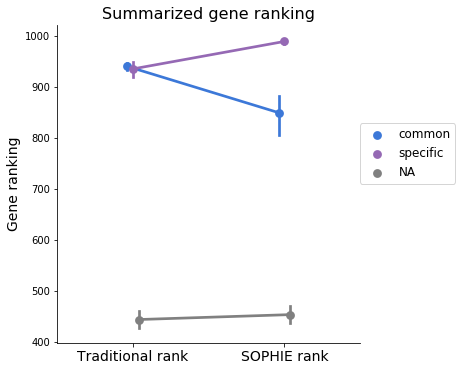

In [43]:
fig_summary = sns.catplot(
    x="variable",
    y="value",
    data=sophie_trad_rank_melt,
    hue="gene type",
    join=True,
    palette=["#3c78d8ff", "#9569b4ff", "grey"],
    hue_order=["common", "specific", "NA"],
    order=["Traditional rank", "SOPHIE rank"],
    dodge=True,
    kind="point",
    legend=False,
)
plt.title("Summarized gene ranking", fontsize=16)
plt.xlabel("")
plt.ylabel("Gene ranking", fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=12, loc=(1.0, 0.5))

fig_summary.savefig(
    "sophie_vs_trad_summary.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

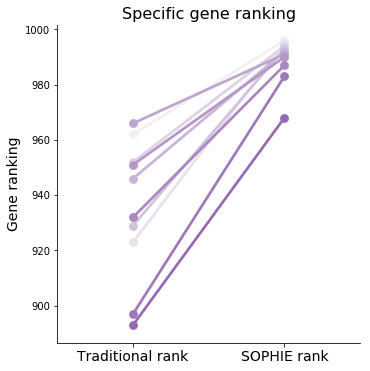

In [44]:
fig_specific = sns.catplot(
    x="variable",
    y="value",
    data=sophie_trad_rank_melt[sophie_trad_rank_melt["gene type"] == "specific"],
    hue="index",
    join=True,
    color="#9569b4ff",
    order=["Traditional rank", "SOPHIE rank"],
    kind="point",
    legend=False,
)
plt.title("Specific gene ranking", fontsize=16)
plt.xlabel("")
plt.ylabel("Gene ranking", fontsize=14)
plt.xticks(fontsize=14)

fig_specific.savefig(
    "sophie_vs_trad_specific.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

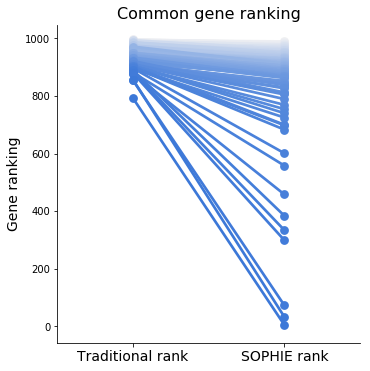

In [45]:
fig_common = sns.catplot(
    x="variable",
    y="value",
    data=sophie_trad_rank_melt[sophie_trad_rank_melt["gene type"] == "common"],
    hue="index",
    join=True,
    color="#3c78d8ff",
    order=["Traditional rank", "SOPHIE rank"],
    kind="point",
    legend=False,
)
plt.title("Common gene ranking", fontsize=16)
plt.xlabel("")
plt.ylabel("Gene ranking", fontsize=14)
plt.xticks(fontsize=14)

fig_common.savefig(
    "sophie_vs_trad_common.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)